# Topic Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Test set

In [2]:
# Check test set classifications
test = pd.read_csv('../../data/fixed-data/topic-test.csv')

test.info()
test.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12694 entries, 0 to 12693
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Headlines  12694 non-null  object
 1   Topic      12694 non-null  object
dtypes: object(2)
memory usage: 198.5+ KB


,Headlines,Topic
count,12694,12694
unique,12694,2
top,"impact of layoffs on economy, services great",Other
freq,1,10648


In [3]:

print(test.tail(10)[['Headlines', 'Topic']])

                                               Headlines      Topic
12684  obama to announce drug overdose prevention mea...      Other
12685         eu wants fishing ban in fifth of north sea      Other
12686  president trump s ban on immigration from iran...      Other
12687     toby mcbeard brings sexy to kids-focused media      Other
12688                 get select all in your inbox daily      Other
12689  new zealand reports return of coronavirus afte...      Other
12690  michael mcqueary, penn state whistleblower in ...      Other
12691  stock market highlights sensex ends 153 points...  Economics
12692             cancer horoscope today august 17, 2020      Other
12693  evidence of developing liquidity crisis xlf an...  Economics


In [4]:
# Class distribution
print(test.groupby('Topic')['Headlines'].count() / len(test))

Topic
Economics    0.161179
Other        0.838821
Name: Headlines, dtype: float64


### Train set

In [5]:
train = pd.read_csv('../../data/fixed-data/topic-train.csv')
val = pd.read_csv('../../data/fixed-data/topic-val.csv')
train = pd.concat([train, val], ignore_index=True)
print(train.groupby('Topic')['Headlines'].count() / len(train))

Topic
Economics    0.157790
Other        0.842208
Name: Headlines, dtype: float64


We're working with an imbalanced dataset.

In [6]:
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975513 entries, 0 to 975512
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Headlines  975511 non-null  object
 1   Topic      975513 non-null  object
dtypes: object(2)
memory usage: 14.9+ MB


,Headlines,Topic
count,975511,975513
unique,975511,2
top,"news roundup for avril 24, 2017",Other
freq,1,821587


Text(0.5, 1.0, 'Other')

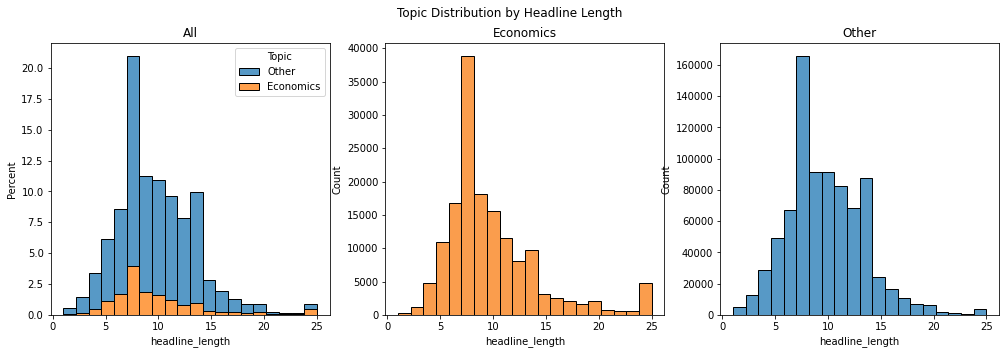

In [7]:
train['Headlines'] = train['Headlines'].astype(str)
train['headline_length'] = train['Headlines'].apply(lambda x: min(len(x.split()), 25))

fig, axes = plt.subplots(ncols=3, figsize=(17, 5))
sns.histplot(data=train, x='headline_length', hue='Topic', multiple='stack', stat='percent',
             bins=20, ax=axes[0])
economics = train[train['Topic'] == 'Economics']
other = train[train['Topic'] != 'Economics']

sns.histplot(data=economics, x='headline_length', color='#f97d11', multiple='stack',
             bins=20, ax=axes[1])
sns.histplot(data=other, x='headline_length', multiple='stack',
             bins=20, ax=axes[2])

fig.suptitle('Topic Distribution by Headline Length')
axes[0].set_title('All')
axes[1].set_title('Economics') 
axes[2].set_title('Other')

The two topics have a somewhat different topic length distributions, which might impact the model negatively.

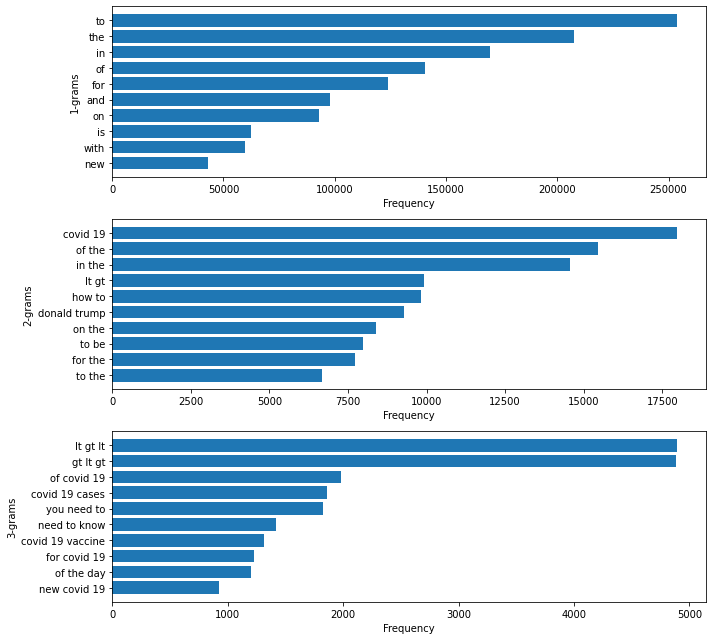

In [8]:
from sklearn.feature_extraction.text import CountVectorizer


def get_ngrams(corpus, ngrams=1, relative=False):
    """Get all n-grams from a corpus of text.
    
    Args:
        corpus: A list of strings representing the text documents.
        ngrams: The size of the n-grams to be extracted (default: 1).
        relative: If True, returns relative frequencies (default: False).
    
    Returns:
        A tuple containing two lists: n-gram words and their corresponding frequencies.
    """
    vec = CountVectorizer(ngram_range=(ngrams, ngrams)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    words, frequencies = zip(*words_freq)
    if relative:
        frequencies = frequencies / np.sum(frequencies)
    return words, frequencies


def plot_top_ngrams(ax, corpus, ngrams=1, top_k=10):
    """Plot the top k n-grams from a corpus of text."""
    words, frequencies = get_ngrams(corpus, ngrams=ngrams)
    words, frequencies = words[:top_k], frequencies[:top_k]
    ax.barh(words, frequencies)
    ax.invert_yaxis()
    ax.set_xlabel('Frequency')
    ax.set_ylabel(f'{ngrams}-grams')


fig, axes = plt.subplots(3, 1, figsize=(10, 9))
plot_top_ngrams(axes[0], train['Headlines'], ngrams=1)
plot_top_ngrams(axes[1], train['Headlines'], ngrams=2)
plot_top_ngrams(axes[2], train['Headlines'], ngrams=3)
plt.tight_layout()
plt.show()

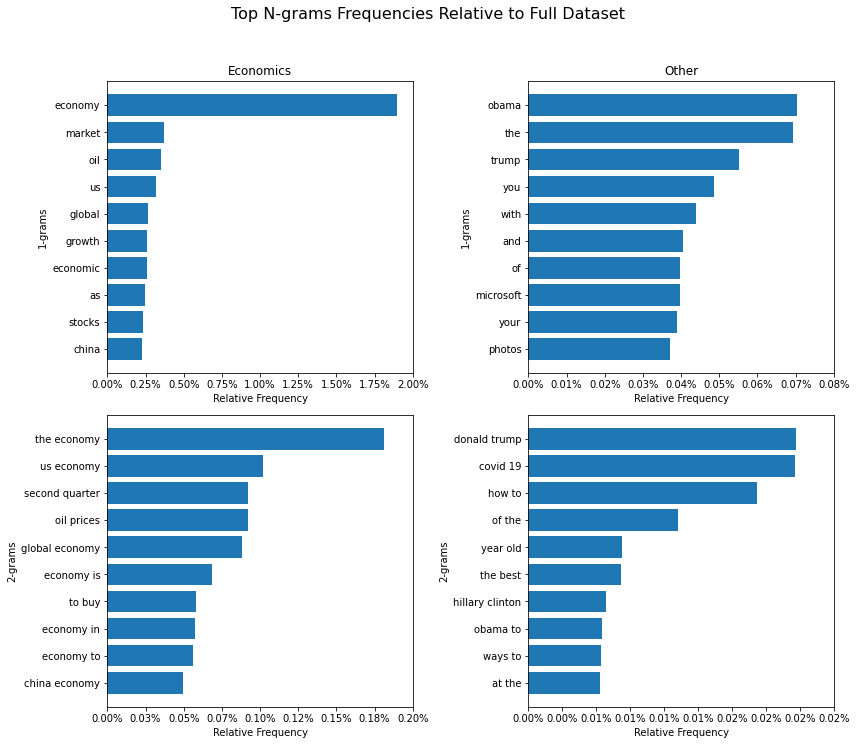

In [9]:
def plot_top_ngrams_relative(ax, corpus, total_counts, ngrams=1, top_k=10):
    """ Plot the top k n-grams relative to the total dataset for a given corpus.
    
    I.e. if 'bull' is 0.2% of the total dataset and 0.6% of the corpus, then the relative
    frequency of 'bull' is 0.6 - 0.2 = 0.4 %.
    
    Args:
        ax: A matplotlib axes object for plotting.
        corpus: A list of strings representing the text documents.
        total_counts: A dictionary containing the total counts of n-grams for all topics.
        ngrams: The size of the n-grams to be extracted (default: 1).
        top_k: The number of top n-grams to display (default: 10).
    """
    word_freq = get_ngrams(corpus, ngrams=ngrams, relative=True)
    relative_word_freq = [(w, f - total_counts[w]) for w, f in zip(*word_freq)]
    words_freq = sorted(relative_word_freq, key=lambda x: x[1], reverse=True)[:top_k]
    words, relative_frequencies = zip(*words_freq)

    ax.barh(words, relative_frequencies)
    ax.invert_yaxis()
    ax.set_xlabel('Relative Frequency')
    ax.set_ylabel(f'{ngrams}-grams')
    # Set x-axis to percentage
    xticks = ax.get_xticks()
    ax.set_xticks(xticks)
    ax.set_xticklabels(['{:,.2%}'.format(x) for x in xticks])


total_1ngrams = get_ngrams(train['Headlines'], ngrams=1, relative=True)
total_1ngrams = dict(zip(*total_1ngrams))
total_2ngrams = get_ngrams(train['Headlines'], ngrams=2, relative=True)
total_2ngrams = dict(zip(*total_2ngrams))

topics = ['Economics', 'Other']
num_topics = len(topics)
fig, axes = plt.subplots(2, num_topics, figsize=(6 * num_topics, 10))

for col, topic in enumerate(topics):
    headlines = train[train['Topic'] == topic]['Headlines']
    axes[0, col].set_title(topic)
    plot_top_ngrams_relative(axes[0, col], headlines, total_counts=total_1ngrams, ngrams=1)
    plot_top_ngrams_relative(axes[1, col], headlines, total_counts=total_2ngrams, ngrams=2)

fig.suptitle('Top N-grams Frequencies Relative to Full Dataset', fontsize=16, y=1.03)
plt.tight_layout()
plt.show()

## Key Findings

After analyzing the dataset, the following key findings have emerged:

- The dataset is imbalanced, with `Other` having significantly more headlines than `Economics`. One potential solution is to optimize a loss function that takes this into account. Alternatively, the `Economics` headlines could be repeated until the dataset is balanced.
- While the frequency of `covid-19` n-grams is still high, it has decreased compared to the previous version of the dataset.
- The sentence length distributions of the two topics are somewhat different, but this difference has significantly decreased compared to the previous dataset.

Overall, the quality of the dataset has improved compared to the previous iteration and is now suitable for training models.

### Earlier Findings

<span style="color: #999999">*This section contains the findings from the previous version of the dataset.*</span>

- The dataset is imbalanced.
    - Either optimize a loss function that takes this into account
    - Or repeat `Economics` headlines until the dataset is balanced.
- The amount of `covid-19` n-grams should be looked into. It means that the COVID-era headlines dominates dataset, which might not represent normal news coverage. 
- The two topics have a very different sentence length distributions.

Overall, the dataset quality should be improved before starting training models.
